# GFlowNets 101: Learning to Sample Happiness
Joseph Viviano & Emmanuel Bengio

(This material was adapted from [Emmanuel Bengio's 2022 Tutorial](https://colab.research.google.com/drive/1fUMwgu2OhYpQagpzU5mhe9_Esib3Q2VR#scrollTo=w51Ha8TRZ29Z)).

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import random

from torch.distributions.categorical import Categorical
import torch
import torch.nn as nn
from tqdm import tqdm, trange

GFlowNets (GFNs) are a generative modelling framwork - we train a model to sample from $p(x)$, i.e., we amortize the cost of sampling into the training process. This means we're going to have a `.sample()` method somewhere to generate an object $x$.

The most common and easiest use-case of a GFN is to sample compositional, discrete objects like sets, sequences, or graphs. The objects are sampled piece-by-piece, i.e., the `.sample()` method iterates over $n$-steps of a `for` loop to generate an object composed of $n$ components.

GFNs are different from "dataset-based" methods (such as variational inference), because we assume instead we have access to an unnormalized density function $R(x)$ which attributes a value to every generated $x$ (a dataset might come into play if $R(x)$ is the result of a model trained on some dataset $D$, but the GFN can be trained using rewards calculated on sampled objects $x \notin D$).

GFNs are different from vanilla RL methods in that wee use the reward to learn $p(x)$, instead of a reward maximizing policy $\pi$. In other words, we seek $p(x) \propto R(x)$.

But first, we're going to define some helper functions (hidden). Make sure to run this cell! Once complete, it will print out the hyperparameters for our models.

# Run Me (below!)

In [3]:
# @title
# These feature globals will be referred to throughout.
_mouth_kwargs = {"closed": False, "fill": False, "lw": 3}
FEATURES = {
    'smile': lambda: plt.gca().add_patch(plt.Polygon(
        np.stack(
            [np.linspace(0.2, 0.8), 0.3 - np.sin(np.linspace(0, 3.14)) * 0.15]
        ).T,
        **_mouth_kwargs
        )
    ),
    'frown': lambda: plt.gca().add_patch(plt.Polygon(
        np.stack(
            [np.linspace(0.2, 0.8), 0.15 + np.sin(np.linspace(0, 3.14)) * 0.15]
        ).T,
        **_mouth_kwargs,
        )
    ),
    'left_eb_down': lambda: plt.gca().add_line(plt.Line2D(
        [0.15, 0.35], [0.75, 0.7], color=(0, 0, 0))
    ),
    'right_eb_down': lambda: plt.gca().add_line(plt.Line2D(
        [0.65, 0.85], [0.7, 0.75], color=(0, 0, 0))
    ),
    'left_eb_up': lambda: plt.gca().add_line(plt.Line2D(
        [0.15, 0.35], [0.7, 0.75], color=(0, 0, 0))
    ),
    'right_eb_up': lambda: plt.gca().add_line(plt.Line2D(
        [0.65, 0.85], [0.75, 0.7], color=(0, 0, 0))
    ),
}


def draw_face(face, title):
    """Given a list of features, render a face to an axis."""
    # Draw the yellow circle & two eyes.
    plt.gca().add_patch(plt.Circle((0.5, 0.5), 0.5, fc=(.9,.9,0))),
    plt.gca().add_patch(plt.Circle((0.25, 0.6), 0.1, fc=(0,0,0))),
    plt.gca().add_patch(plt.Circle((0.75, 0.6), 0.1,  fc=(0,0,0)))

    for feat in face:
        FEATURES[feat]()

    plt.axis('scaled')
    plt.axis('off')
    if title:
        plt.gca().set_title(title)


# Some utility functions:
def plot_loss_curve(losses_A, losses_B=None, title=""):

    plt.figure(figsize=(10,3))

    if isinstance(losses_B, type(None)):
        plt.plot(losses, color="black")
    else:
        plt.plot(losses_A, color="blue", linewidth=1, label="No Forward Masks")
        plt.plot(losses_B, color="red", linewidth=1, label="Forward Masks", alpha=0.5)
        plt.legend()

    plt.yscale('log')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title(title)


def check_sampled_faces(sampled_faces):

    fig, ax = plt.subplots(8, 8, figsize=(4,4))

    n = 128  # final n samples to calculate stats over.
    n_plot = 64  # 8 x 8
    print('Ratio of faces with a smile:{}, ideal={}'.format(
        sum(['smile' in i for i in sampled_faces[-n:]]) / n,
        2/3.,
    ))
    print('Proportion of valid faces:{}, ideal=1'.format(
        sum([face_reward(i) > 0 for i in sampled_faces[-n:]]) / n
    ))

    for i, face in enumerate(sampled_faces[-n_plot:]):
      plt.sca(ax[i//8, i%8])
      draw_face(face, "")


def analyze_torchgfn_results(visited_terminating_states, env, n_samples = 128):

    env = FacesEnv()

    # Calculate sample stats.
    n_samples = 128
    smiles = visited_terminating_states[-n_samples:].tensor[:, -2]
    frowns = visited_terminating_states[-n_samples:].tensor[:, -1]
    print("proportion of smiles:frowns = {}:{}".format(
        torch.mean(smiles),
        torch.mean(frowns),
        )
    )

    # Generate smilies in string format.
    sampled_faces = []
    for s in visited_terminating_states[-n_samples:]:
        face = []
        for i, elem in enumerate(s.tensor.tolist()):
            if elem == 1:
                face.append(env.feature_keys[i])
        sampled_faces.append(face)

    # Plot smilies.
    fig, ax = plt.subplots(8, 8, figsize=(4, 4))
    n_plot = 64  # 8 x 8
    for i, face in enumerate(sampled_faces[-n_plot:]):
        plt.sca(ax[i//8, i%8])
        draw_face(face, "")


def recursively_enumerate(s, enumerated_states, transitions, only_valid=True):

    # Detects invalid configurations.
    if only_valid:
        if has_overlap(s):
            return
    else:
        if len(set(s)) < len(s):  # Don't allow for duplicates.

            return
        elif len(s) > 3:  # Max trajectory length.
            return

    for i in FEATURE_KEYS:
        if i not in s:
            recursively_enumerate(
                s + [i],
                enumerated_states,
                transitions,
                only_valid=only_valid
            )

    enumerated_states.append(s)
    transitions.append((s[:-1], s))


def get_unique(l: list):

    unique = []
    for i in map(set, l):
      if i not in unique:
        unique.append(i)

    return sorted(map(tuple, unique))


def get_face_positions_and_plot(enumerated_states, transitions, F_sa = None):
    """Plot a graph of all state transitions.

    If a GFlowNet state flow estimator if provided, the edges of the graph will be
    colors according to the flows.
    """
    use_flows = True if not isinstance(F_sa, type(None)) else False

    lens, levels = [], []
    face2pos = {}

    for i in range(4):  # All valid trajectories are length 4 (including s0).
        lens.append(len([j for j in enumerated_states if len(j) == i]))
        levels.append(sorted([j for j in enumerated_states if len(j) == i]))

    fig = plt.figure(figsize=(8, 8))

    # Maps from unique face hashes to unique (x,y) coorindates for plotting.
    for i, (level, L) in enumerate(zip(levels, lens)):
        for j, face in enumerate(level):
            ax = fig.add_axes([j/L, i/4, 1/L, 1/6])
            draw_face(face, "")
            face2pos[face_hash(face)] = (j/L + 0.5/L, i/4)

    ax = fig.add_axes([0, 0, 1, 1])
    plt.sca(ax)
    plt.gca().set_facecolor((0, 0, 0, 0))
    plt.xlim(0,1)
    plt.ylim(0,1)

    # Now add all transitions (arrows).
    if use_flows:
      max_flow = 0

    for face_a, face_b in transitions[1:]:

        if not len(face_b):  # We're at the end of the trajectory.
          continue

        pos_a, pos_b = face2pos[face_hash(face_a)], face2pos[face_hash(face_b)]

        # Optionally color the arrows by the learned flows.
        if use_flows:
            Fstate = F_sa(face_to_tensor(face_a))  # State flow.

            Fa = Fstate[
                FEATURE_KEYS.index([i for i in face_b if i not in face_a][0])
            ].item()
            c = cm.Reds(Fa)

            if Fa > max_flow:
              max_flow = Fa

        la = int(pos_a[1] * 4)
        lb = int(pos_b[1] * 4)
        ws = [1/6, 1/6, 0.13, 0.11]
        plt.arrow(
            pos_a[0],
            pos_a[1] + ws[la],
            pos_b[0] - pos_a[0],
            pos_b[1] - pos_a[1] - ws[lb],
            head_width=0.01,
            width=0.003,
            ec=c if use_flows else (1, 0, 0),
            fc=c if use_flows else (0, 0, 0),
            length_includes_head=True,
        )
        plt.axis('off')

    if use_flows:
        ax = fig.add_axes([1, 0.2, 0.05, 0.6])
        plt.sca(ax)
        fig.colorbar(
            cm.ScalarMappable(
                norm=cm.colors.Normalize(vmin=0, vmax=max_flow),
                cmap=cm.Reds,
            ),
            cax=ax,
            label='Edge Flow',
        )

    plt.suptitle("Smiley State Space")


def plot_state_space(model=None):
    """Get all of the unique possible states and their transitions, then plot."""
    enumerated_states, transitions = [], []
    recursively_enumerate([], enumerated_states, transitions, only_valid=False)
    unique_enumerated_states = get_unique(enumerated_states)
    if isinstance(model, type(None)):
        get_face_positions_and_plot(unique_enumerated_states, transitions)
    else:
        get_face_positions_and_plot(unique_enumerated_states, transitions, F_sa=F_sa)


def face_hash(face):
    """Returns a binary hash for each submitted face."""
    return tuple([i in face for i in FEATURE_KEYS])


def face_to_tensor(face, verbose=False):
  """Encodes a face as a binary tensor (converted to float32)."""
  if verbose:
      print("face={}, hash={}, tensor={}".format(
          face,
          face_hash(face),
          torch.tensor(face_hash(face)).float(),
          )
      )
  return torch.tensor(face_hash(face)).float()


def set_seed(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Our feature space. A face has one mouth, one left eyebrow, and one right eyebrow.
MOUTHS = ["smile", "frown"]
LEFT_EB = ["left_eb_down", "left_eb_up"]
RIGHT_EB = ["right_eb_down", "right_eb_up"]
FEATURE_KEYS = MOUTHS + LEFT_EB + RIGHT_EB

# Fixed hyperparameters.
n_hid_units = 512
n_episodes = 10_000
learning_rate = 3e-3
seed = 42

print("For all experiments, our hyperparameters will be:")
print("    + n_hid_units={}".format(n_hid_units))
print("    + n_episodes={}".format(n_episodes))
print("    + learning_rate={}".format(learning_rate))
print("    + seed={}".format(seed))

For all experiments, our hyperparameters will be:
    + n_hid_units=512
    + n_episodes=10000
    + learning_rate=0.003
    + seed=42


# Features: Faces, Both Happy and Sad

For this simple example, we will generate 😀 & 🙁 faces!

Here, we define a face of being composed of two eyebrows (each can be up or down) and a mouth (smiling or frowning), for a total of 6 `FEATURES`:


*   `smile`
*   `frown`
*   `left_eb_down`
*   `left_eb_up`
*   `right_eb_down`
*   `right_eb_up`

(where `eb` is shorthand for `eyebrow`). Above, we defined our feature space and some helper functions which we will use throughout the tutorial (we've also hidden some helper code for brevity).

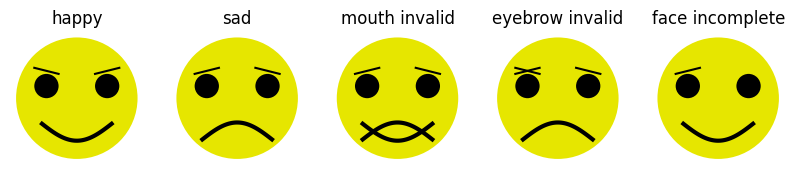

In [4]:
f, ax = plt.subplots(1, 5, figsize=(10, 50))
plt.sca(ax[0])
draw_face(['smile', 'left_eb_down', 'right_eb_down'], "happy")
plt.sca(ax[1])
draw_face(['frown', 'left_eb_up', 'right_eb_up'], "sad")
plt.sca(ax[2])
draw_face(['smile', 'frown', 'left_eb_up', 'right_eb_up'], "mouth invalid")
plt.sca(ax[3])
draw_face(['frown', 'left_eb_up', 'left_eb_down', 'right_eb_up'], "eyebrow invalid")
plt.sca(ax[4])
draw_face(['smile', 'left_eb_up'], "face incomplete")

# The Reward Function

A face is defined as a list of these keys. For example, above `['smile', 'left_eb_down', 'right_eb_down']` gives a happy face, and `['frown', 'left_eb_up', 'right_eb_up']` gives a sad face. Meanwhile other configurations give invalid faces, e.g., with multiple overlapping mouths or eyebrows, or not having two eyebrows in one mouth.

If we want to train a GFN to sample faces, we first need to define a **reward function** which expresses the above intention. We want to only reward valid faces: those with two non-overlapping eyebrows and one mouth. If there are missing parts or two overlapping parts the reward is 0. Also, since it's better to be happy than sad, let's sample happy faces more often, by giving them a reward of 2, and sad faces a reward of 1.

Since our trained sampler should respect $p(x) \propto R(x)$, **at convergence** we should sample twice as many smiles as frowns! Note - we often don't *completely* converge without training for a long time, so we might not observe a $p(x)$ exactly proportional to $R(x)$.

In [5]:
def has_overlap(face: list):
  """"Checks whether face contains either overlapping eyebrows or mouths."""
  if 'left_eb_down' in face and 'left_eb_up' in face:
    return True

  if 'right_eb_down' in face and 'right_eb_up' in face:
    return True

  if 'smile' in face and 'frown' in face:
    return True

  return False


def face_reward(face):
  """Reward is 0 with incomplete/incorrect faces, 1 for sad, and 2 for happy."""
  # A face cannot have overlapping features.
  if has_overlap(face):
    return 0  # We will only very rarely sample an invalid face.

  # A face must have exactly two eyebrows.
  if sum([i in face for i in LEFT_EB + RIGHT_EB]) != 2:
    return 0

  if 'smile' in face:
    return 2  # We want twice as many happy faces as sad faces.

  if 'frown' in face:
    return 1  # We want half as many happy sad faces as happy faces.

  return 0  # If we reach this point, there's no mouth.

# State Space

Now that we've defined a reward function, let's take a look at what the state space looks like. We want to see all the possible routes to a valid terminal state.

By state space, we mean the **space of intermediate constructions**, i.e. in this case this will include both partially created faces and fully created faces. For this tutorial we refer to these states as $s$, and to the full constructions as both $x$ and $s$ interchangeably (because $\mathcal{X} \subset \mathcal{S}$).

As you can see, we start with a base face that has just two eyes and we progressively add all possible patches that make a valid face. We call one such construction path from bottom to top a _trajectory_ or an _episode_.

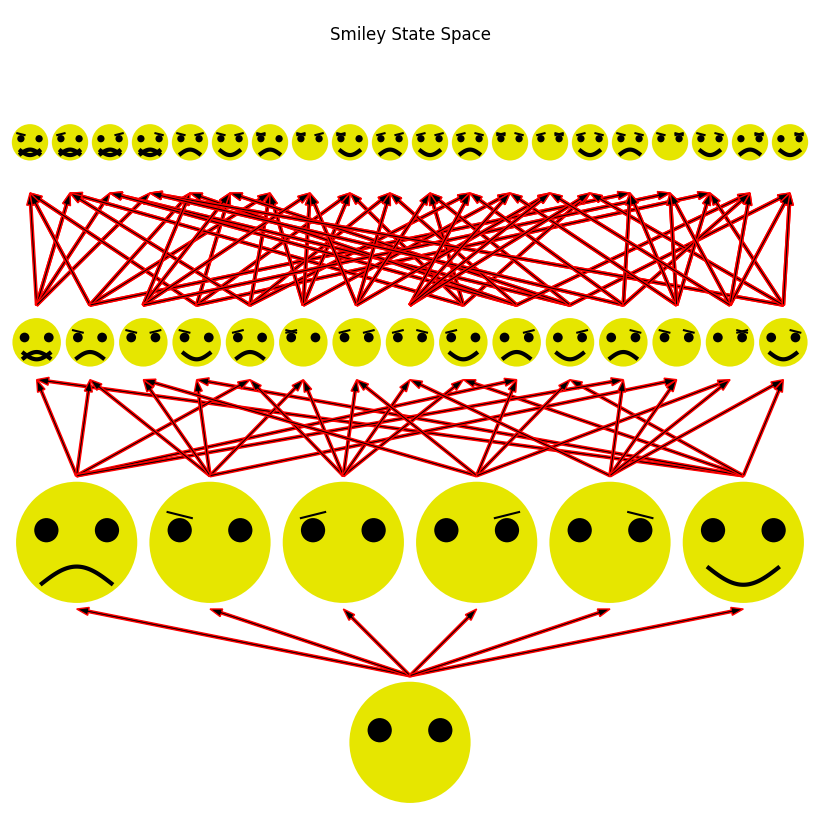

In [6]:
plot_state_space()

The directed acyclic graph (DAG) above can be thought of as the unrolling of the `for` loop of the generation process, which allows us to visualize all possible paths. In Reinforcement Learning we'd call this the Markov Decision Process (MDP).

What we're interested in is a _policy_, something that will tell us at each step what action to take (what patch to add). Since we are interested in learning a distribution, the policy itself will be a distribution over actions (possible patches to add) which is typically written $\pi(a|s)$ in RL, but which we'll call $P_F$ ($F$ for forward) here. We'll call these arrows above, the $(s,s')$ pairs (or equivalently, $(s,a)$ pairs), _edges_, and the set of all edges $\mathcal{E}$.

The main idea behind GFlowNet is to interpret the DAG as a **flow network**. You could imagine each edge in the graph as a pipe through which some amount of water, or particles, _flows_. We then want to _find_ a flow where, (a) flow is preserved (meaning the amount of water going into a node should equal the amount of water going out of a node), and (b) the flow coming into a terminal state (a finished object) is equal to its reward (and in fact every non-terminal state _does not have any reward_).

> "Network" here thus does _not_ refer to a _neural_ network architecture - it's not the "Net" in "ConvNet" - it refers to the MDP. So we use a GFlowNet, powered by a neural network, to discover the flows of the state space network. Naming is hard 😉.

A central finding of the first GFlowNet paper is that if we match to each edge a _flow_, $F(s,s')>0$, and that this flow respects the following property:
$$\forall s', \sum_{s: (s,s')\in\mathcal{E}} F(s,s') = R(s') + \sum_{s'':(s',s'')\in\mathcal{E}} F(s',s'')$$
which ensures _flow consistency_, AND we define the following policy
$$P_F(s'|s) = \frac{F(s, s')}{\sum_{s''}F(s, s'')}$$
which allows us to sample trajectories (paths through the DAG) using this policy, we will sample terminal states (finished objects $x$) with probability:

$$p(x) \propto R(x)$$.

### Building and training a flow model with flow-matching

We'll now setup a model and train it with the _flow-matching_ loss, introduced in [Flow Network based Generative Models for Non-Iterative Diverse Candidate Generation, Emmanuel Bengio, Moksh Jain, Maksym Korablyov, Doina Precup, Yoshua Bengio](https://arxiv.org/abs/2106.04399)

Now that we know we want to predict edge flows, we need to define some model which does that. We could use a model that is a function of a pair of states, but that's not too efficient (exercise left to the reader ;). Instead we'll take inspiration from RL and model a function of a single state which outputs multiple predictions at once, the flow for each possible child of that state.

In other words, we train a model `F(state)` which outputs a vector which is indexed by the action used to reach a child of `state`, i.e. $F(s,s')$ is `F(s)[a]` if `a` leads from $s$ to $s'$ (e.g. `a` can be, "add a raised eyebrow").

In [7]:
class FlowModel(nn.Module):
  def __init__(self, num_hid):
    super().__init__()
    self.mlp = nn.Sequential(
        nn.Linear(6, num_hid),  # Input state is a binary vector representing feature
                                # presence and/or absence.
        nn.LeakyReLU(),
        nn.Linear(num_hid, 6)  # Output 6 numbers for the 6 actions (child states).

    )

  def forward(self, x):
    return self.mlp(x).exp()  # Flows must be positive, so we take the exponential.

In [8]:
test = FlowModel(15)
test(torch.tensor([0, 1, 0, 0, 0, 0], dtype=torch.float32))

tensor([1.2812, 1.2225, 0.7281, 0.8476, 0.9972, 1.2918],
       grad_fn=<ExpBackward0>)

Another important thing we need to define is how we deal with parents. Since we'll be using the flow-matching objective to make the _flow consistency_ equation respected, we need to be able to enumerate the $(s, s')$ pairs that are "parents" of $s'$.

In the left sum $$\sum_{s: (s,s')\in\mathcal{E}} F(s,s') = R(s') + \sum_{s'':(s',s'')\in\mathcal{E}} F(s',s'')$$
the set $\{s: (s,s')\in\mathcal{E}\}$ is the set of parents of $s'$, while in the right sum, it is the set of children of $s'$. Since we're parameterizing $F$ with something that outputs a vector, computing the sum over children flows on the right is easy, we simply take `F(s').sum()`. But on the left, we need to do one forward pass for each parent to basically take `sum([F(ps)[pa] for ps, pa in parents(s')])` (we will see later in the tutorial that this is avoidable).

Note - you might need `FEATURE_KEYS`, a variable containing the list of feature keys pre-defined for you, for the following exercises. This can be used to index the actions and states vectors.

In [9]:
print("FEATURE_KEYS={}".format(FEATURE_KEYS))

FEATURE_KEYS=['smile', 'frown', 'left_eb_down', 'left_eb_up', 'right_eb_down', 'right_eb_up']


In [10]:
test = ['smile'] + [FEATURE_KEYS[1]]
whut = test.copy()
whut.remove('smile')
whut, test

(['frown'], ['smile', 'frown'])

In [11]:
def face_parents(state):
  parent_states = []  # States that are parents of state.
  parent_actions = []  # Actions that lead from those parents to state.

  for feature in state:
    # For each face part, there is a parent without that part.
    temp = state.copy()
    temp.remove(feature)

    parent_states.append(temp)  # TODO: implement.

    # The action to get there is the corresponding index of that face part.
    parent_actions.append(FEATURE_KEYS.index(feature))  # TODO: implement.

  return parent_states, parent_actions

Finally, to actually train the model we'll use the simplest differentiable loss possible, by just turning the above equation into a mean squared error (there are more efficient losses, but we will start with this as it is simplest):
$$L(s') = \left(\sum_{s: (s,s')\in\mathcal{E}} F(s,s') - R(s') - \sum_{s'':(s',s'')\in\mathcal{E}} F(s',s'')\right)^2$$

In [12]:
def flow_matching_loss(incoming_flows, outgoing_flows, reward):
    """Flow matching objective converted into mean squared error loss."""
    return (incoming_flows.sum() - reward - outgoing_flows.sum())**2  # TODO: implement.

# Hyperparameters

Previously, we defined some hyperparameters that we will use for all following demonstrations:

In [13]:
# @title
print("For all experiments, our hyperparameters will be:")
print("    + n_hid_units={}".format(n_hid_units))
print("    + n_episodes={}".format(n_episodes))
print("    + learning_rate={}".format(learning_rate))

For all experiments, our hyperparameters will be:
    + n_hid_units=512
    + n_episodes=10000
    + learning_rate=0.003


We're now ready to instantiate and train the model. First, we let the model generate its own data by following its own policy (i.e., sampling actions based on edge flow predictions), and simply train on that data. Let's go through this code and then run it for a minute.

Note: in the below, `state` is a list of strings representing the keys in `FEATURE_KEYS`, present on the face.

In [14]:
face_reward(['smile', 'left_eb_down', 'right_eb_down'])

2

In [16]:
set_seed(seed)

# Instantiate model n_hid_units optimizer
F_sa = FlowModel(n_hid_units)
opt = torch.optim.Adam(F_sa.parameters(), learning_rate)

# To not complicate the code, I'll just accumulate losses here and take a
# gradient step every `update_freq` episode (at the end of each trajectory).
losses, sampled_faces = [], []
minibatch_loss = 0
update_freq = 4

tbar = trange(n_episodes, desc="Training iter")
for episode in tbar:
    state = []  # Each episode starts with an empty state.
    edge_flow_preds = F_sa(face_to_tensor(state))  # Predict F(s, a).

    for t in range(3):  # All trajectories are length 3 (not including s0).
        # Normalizing gives us the probability of each action, from which we can
        # sample actions to obtain the next state.

        # Sample the action and compute the new state.
        policy = edge_flow_preds/torch.sum(edge_flow_preds)  # TODO: Complete.
        # We want to sample from the policy here (a Categorical distribution...)
        action = Categorical(probs=policy).sample()  # TODO: Complete.
        new_state = state + [FEATURE_KEYS[action]]

        # To compute the loss, we'll first enumerate the parents, then compute
        # the edge flows F(s, a) of each parent, indexing to get relevant flows.
        parent_states, parent_actions = face_parents(new_state)
        ps = torch.stack([face_to_tensor(p) for p in parent_states])
        pa = torch.tensor(parent_actions).long()
        testing = F_sa(ps)
        parent_edge_flow_preds = testing[torch.arange(len(parent_states)), pa]

        if t == 2:  # End of trajectory.
            # We calculate the reward and set F(s,a) = 0 \forall a, since there
            # are no children of this state.
            reward = face_reward(new_state)  # TODO: To Complete.
            edge_flow_preds = torch.zeros(len(FEATURE_KEYS))  # TODO: To Complete.
        else:
            # We compute F(s, a) and set the reward to zero.
            reward = 0  # TODO: To Complete.
            edge_flow_preds = F_sa(face_to_tensor(new_state))  # TODO: To Complete.

        # print(parent_edge_flow_preds)
        # print(edge_flow_preds)
        # print(reward)

        minibatch_loss += flow_matching_loss(  # Accumulate.
            parent_edge_flow_preds,
            edge_flow_preds,
            reward,
        )
        state = new_state  # Continue iterating.
    
    # print(pa)
    # print(testing)
    # print(parent_edge_flow_preds)
    # print([FEATURE_KEYS[action]])
    # print(edge_flow_preds)
    # print(parent_states)
    # print(parent_actions)

    # We're done with the episode, add the face to the list, and if we are at an
    # update episode, take a gradient step.
    sampled_faces.append(state)
    if episode % update_freq == 0:

        # Normalize accumulated loss.
        minibatch_loss = minibatch_loss / (update_freq)
        losses.append(minibatch_loss.item())
        tbar.set_description("Training iter (loss={:.6f})".format(minibatch_loss))
        minibatch_loss.backward()
        opt.step()
        opt.zero_grad()
        minibatch_loss = 0

Training iter (loss=0.379622): 100%|██████████| 10000/10000 [00:27<00:00, 367.23it/s]


*We* now trained the model for a little while. It's not perfect but the loss seems low enough:

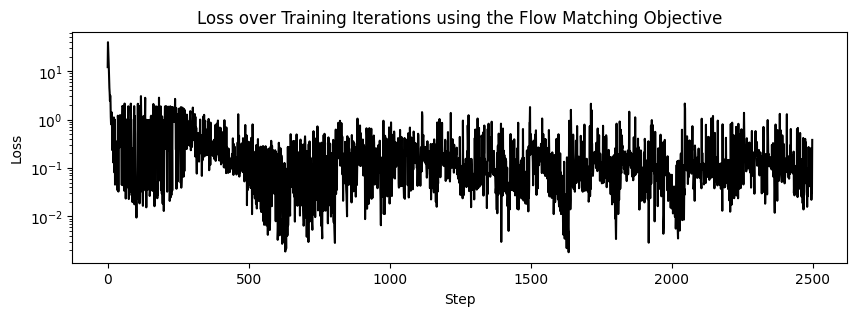

In [144]:
plot_loss_curve(losses, title="Loss over Training Iterations using the Flow Matching Objective")

Let's see what kind of faces the model is generating. Remember that we set the reward of smiling faces to 2 and the reward of frowny faces to 1. Since there are 4 possible smile and frown faces respectively (i.e. an equal number), we should expect there to be 2/3 smiling faces and 1/3 frowny faces when sampling from the model:

Ratio of faces with a smile:0.703125, ideal=0.6666666666666666
Proportion of valid faces:0.8828125, ideal=1


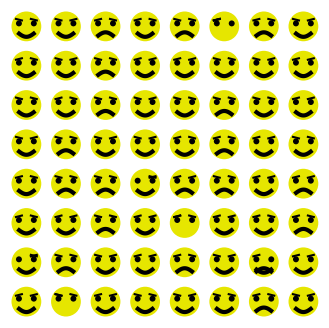

In [145]:
check_sampled_faces(sampled_faces)

And we can visualize the edge flows. Note two things:



*   Flows near the source node (initial state) are generally larger than terminal flows.
*   The model has learned to ascribe low flows to invalid configurations.



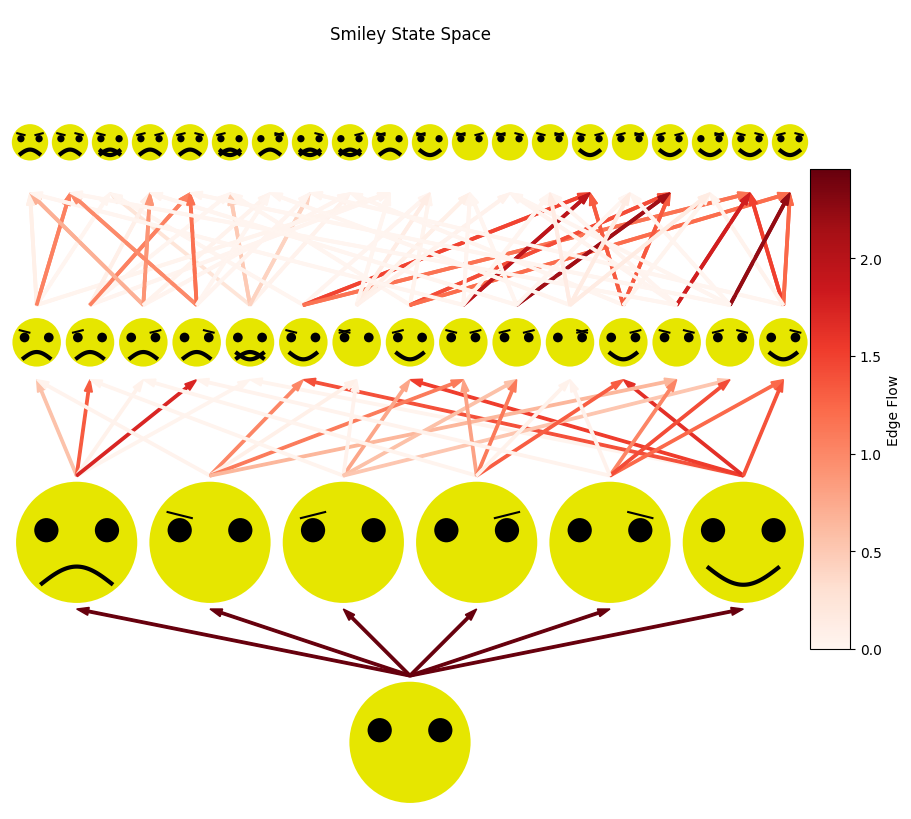

In [146]:
plot_state_space(model=F_sa)

Well, the results look OK, but not great. We're still sampling invalid faces, and we're not sampling the correct proportion of happy to sad faces.

One interesting side effect of training a GFlowNet model is that the flow of the initial state _is the partition function_. $F(s_0)$ is the sum of all rewards in the network (in the state space) since, in terms of flows, it is the unique source to all the sinks (which each sink in $R(x)$ flow).

Since we have 4 terminal smiling states and 4 frowny ones with rewards 2 and 1 respectively, the total reward is $8 + 4 = 12$. Let's see if the model has learned that:

In [147]:
print("The final Z (partition function) estimate is {:.2f}".format(
    F_sa(face_to_tensor([])).sum())
)

The final Z (partition function) estimate is 9.19


We're heading in the right direction, but we aren't there yet.

# Action Masking

At this point you might be wondering: if we don't want our trained sampler to ever sample an invalid face, why should we allow it turing training? That's a big waste of time. You would be right. We can learn to not sample a particular face by providing a low reward for that face and training for long enough, but we can also simply disallow that face from being constructed in the first place by masking those actions during training. This greatly speeds up convergence, and is a common practice when using GFNs with reasonably challenging applications.

We'll calculate a mask which we apply to the `edge_flow_preds` vector (our unnormalized distribution over next actions), such that we never sample a masked state. Otherwise, our training loop remains the same.

Hint: You might need to know the `FEATURE_KEYS` here...

In [148]:
print("FEATURE_KEYS={}".format(FEATURE_KEYS))

FEATURE_KEYS=['smile', 'frown', 'left_eb_down', 'left_eb_up', 'right_eb_down', 'right_eb_up']


In [180]:
def calculate_forward_mask_from_state(state):
    """Here, we mask forward actions to prevent the selection of invalid configurations.
        Recall our feature space is:
            [smile, frown, left_eb_down, left_eb_up, right_eb_down, right_eb_up]
        So we can only select one element from [0,1], [2,3], and [4,5].
    """
    mask = np.ones(6)  # Allowed actions represented as 1, disallowed actions as 0.

    # TODO: Complete logic:
    if "smile" in state or "frown" in state:
        mask[:2] = 0
    if "left_eb_down" in state or "left_eb_up" in state:
        mask[2:4] = 0
    if "right_eb_down" in state or "right_eb_up" in state:
        mask[4:] = 0

    return torch.Tensor(mask).bool()

Now let's mask the `edge_flow_preds`...

In [181]:
set_seed(seed)

# Instantiate model and optimizer
F_sa = FlowModel(n_hid_units)
opt = torch.optim.Adam(F_sa.parameters(), learning_rate)

# To not complicate the code, I'll just accumulate losses here and take a
# gradient step every `update_freq` episode (at the end of each trajectory).
losses_masking, sampled_faces = [], []
minibatch_loss = 0
update_freq = 4

tbar = trange(n_episodes, desc="Training iter")
for episode in tbar:
    state = []  # Each episode starts with an empty state.
    edge_flow_preds = F_sa(face_to_tensor(state))  # Predict F(s, a).

    for t in range(3):  # All trajectories are length 3 (not including s0).

        # Here we mask the relevant forward actions.
        mask = calculate_forward_mask_from_state(state)
        edge_flow_preds = edge_flow_preds*mask  # TODO: Complete.

        # Normalizing gives us the probability of each action, from which we can
        # sample actions to obtain the next state.
        policy = edge_flow_preds / edge_flow_preds.sum()
        action = Categorical(probs=policy).sample()
        new_state = state + [FEATURE_KEYS[action]]

        # To compute the loss, we'll first enumerate the parents, then compute
        # the edge flows F(s, a) of each parent, indexing to get relevant flows.
        parent_states, parent_actions = face_parents(new_state)
        ps = torch.stack([face_to_tensor(p) for p in parent_states])
        pa = torch.tensor(parent_actions).long()
        parent_edge_flow_preds = F_sa(ps)[torch.arange(len(parent_states)), pa]

        if t == 2:  # End of trajectory.
            # We calculate the reward and set F(s,a) = 0 \forall a, since there
            # are no children of this state.
            reward = face_reward(new_state)
            edge_flow_preds = torch.zeros(6)
        else:
            # We compute F(s, a) and set the reward to zero.
            reward = 0
            edge_flow_preds = F_sa(face_to_tensor(new_state))

        minibatch_loss += flow_matching_loss(  # Accumulate.
            parent_edge_flow_preds,
            edge_flow_preds,
            reward,
        )
        state = new_state  # Continue iterating.

    # We're done with the episode, add the face to the list, and if we are at an
    # update episode, take a gradient step.
    sampled_faces.append(state)
    if episode % update_freq == 0:

        # Normalize accumulated loss.
        minibatch_loss = minibatch_loss / (update_freq)
        losses_masking.append(minibatch_loss.item())
        tbar.set_description("Training iter (loss={:.6f})".format(minibatch_loss))
        minibatch_loss.backward()
        opt.step()
        opt.zero_grad()
        minibatch_loss = 0

Training iter (loss=0.000103): 100%|██████████| 10000/10000 [00:24<00:00, 410.40it/s]


We can see this had a big effect on convergence:

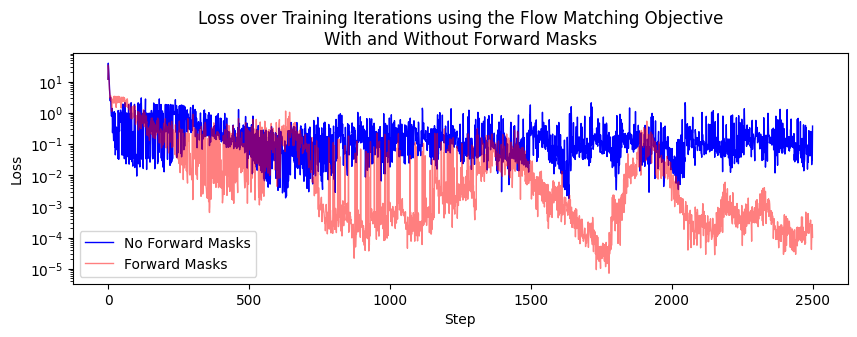

In [182]:
plot_loss_curve(
    losses,
    losses_B=losses_masking,
    title="Loss over Training Iterations using the Flow Matching Objective\nWith and Without Forward Masks"
)

And we can also see a big change in the sampling distribution. Namely, we are now sampling only valid configurations, and the sampling proportion is pretty close.

Ratio of faces with a smile:0.578125, ideal=0.6666666666666666
Proportion of valid faces:1.0, ideal=1


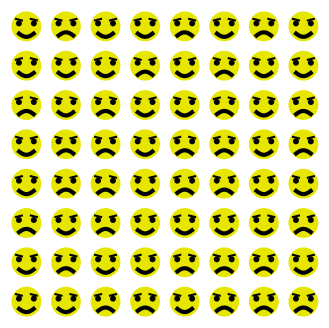

In [183]:
check_sampled_faces(sampled_faces)

And our estimate of the partition function is improved, but not yet there:

In [184]:
print("The final Z (partition function) estimate is {:.2f}".format(
    F_sa(face_to_tensor([])).sum()
    )
)

The final Z (partition function) estimate is 14.14


# Trajectory Balance

[Trajectory Balance: Improved Credit Assignment in GFlowNets, Nikolay Malkin, Moksh Jain, Emmanuel Bengio, Chen Sun, Yoshua Bengio](https://arxiv.org/abs/2201.13259)

So far we've thought of flow-consistency very locally by considering a single state and looking at all the flow coming into that state and out of that state.

Let's instead think about the flow _trajectories_ $\tau$. If you think of all the possible paths from the initial state $s_0$ to some state $s$, each path can be "assigned" some amount of flow (just as we "assigned" flows to edges earlier). If we adopt this view, we can say we want all of the trajectory flows that go to a state to equal its reward (just like we wanted all incoming flows to a terminal state to be equal to its reward $R(x)$).

$$F(s) = \sum_{\tau, s\in\tau} F(\tau)$$

We can also write the probability of a particular trajectory as the product of its policy steps:

$$P(\tau) = \prod_{(s,s') \in \tau} P_F(s'|s) =\frac{1}{Z}F(\tau)$$.

Note the relationship of $P(\tau)$ with $F(\tau)$, which asks "what fraction of the total flow $Z$ goes through $\tau$?".

We can equivilantly think of _backward_ trajectories using a backward policy $P_B$, which gives the distribution over the parents of a state, with the following property

$$P(\tau) = \prod_{(s,s') \in \tau} P_B(s|s')$$

A bit of rearranging (see paper), let $\tau=(s_0,...,s_n=x)$ gives us this equality:

$$Z \prod_{t} P_F(s_{t+1}|s_t) = R(x)\prod_t P_B(s_t|s_{t+1})$$


Here's an intuitive view of what this means. Since all the incoming flow to a terminal state must be preserved, you can think of it being "split up" into different flows (one for each parent of that state). Since $P_B$ is a distribution, and therefore sums to 1, it does that splitting.

> $R(x)\prod_t P_B(s_t|s_{t+1})$ represents "what fraction of the reward goes through this particular trajectory?"

The other side of this equation insteads splits up the partition function $Z$.

> $Z \prod_{t} P_F(s_{t+1}|s_t)$ represents "what fraction of the partition function goes through this trajectory?"

and the equality enforces that those two quantities are equal.

## Implementing Trajectory Balance

Since we assume $R(x)$ is given, we'll now need to estimate $Z$, $P_B$ and $P_F$. In the last exercise, we modeled $F(s,a)$ directly, but as the number of states grows, this is not ideal. Instead, implementations of GFlowNet typically model $\log F(s, a)$ (just like we typically train classifiers with a logsoftmax rather than predicting the probabilities directly). We will do the same thing here and actually estimate $\log Z$ as well as the logits of $P_B$ and $P_F$.

In [185]:
class TBModel(nn.Module):
  def __init__(self, num_hid):
    super().__init__()
    self.mlp = nn.Sequential(
        nn.Linear(6, num_hid),  # 6 input features.
        nn.LeakyReLU(),
        nn.Linear(num_hid, 12),  # 12 outputs: 6 for P_F and 6 for P_B.
    )
    self.logZ = nn.Parameter(torch.ones(1))  # log Z is just a single number.

  def forward(self, x):
    logits = self.mlp(x)
    # Slice the logits into forward and backward policies.
    P_F = logits[..., :6]
    P_B = logits[..., 6:]

    return P_F, P_B

Just like we turned the flow-matching equation into a MSE loss, we will use the following loss for a trajectory:
$$L(\tau) = \left(\log \frac{Z_\theta \prod_t P_F(s_{t+1}|s_t;\theta)}{R(x)\prod_t P_B(s_t|s_{t+1}; \theta)} \right)^2$$

or equivalently
$$L(\tau) = \left(\log Z_\theta + \sum_t \log P_F(s_{t+1}|s_t;\theta) - \log R(x) - \sum_t \log P_B(s_t|s_{t+1}; \theta) \right)^2$$

You may notice that in this loss there is no need to compute parents! In the current toy example this won't make a difference, but when generating complex objects this saves us O(average number of parents) forward passes.



In [186]:
def trajectory_balance_loss(logZ, log_P_F, log_P_B, reward):
    """Trajectory balance objective converted into mean squared error loss."""
    return (logZ + log_P_F - torch.log(reward) - log_P_B)**2  # TODO: Complete.

We also need, for the backward policy, to be able to calculate valid backward actions:

In [187]:
def calculate_backward_mask_from_state(state):
    """Here, we mask backward actions to only select parent nodes."""
    # This mask should be 1 for any action that could have led to the current state,
    # otherwise it should be zero.
    return torch.Tensor(
        [1 if feature in state else 0 for feature in FEATURE_KEYS]
    ).bool()

Again we will roll out trajectories, then compute the loss after each trajectory and take gradient steps at some frequency. Let's train the model for a minute.

In [188]:
set_seed(seed)

# Instantiate model and optimizer
model = TBModel(n_hid_units)
opt = torch.optim.Adam(model.parameters(),  learning_rate)

# To not complicate the code, I'll just accumulate losses here and take a
# gradient step every `update_freq` episode (at the end of each trajectory).
losses, sampled_faces, logZs = [], [], []
minibatch_loss = 0
update_freq = 4

for episode in tqdm(range(n_episodes), ncols=40):
    state = []  # Each episode starts with an empty state.
    P_F_s, P_B_s = model(face_to_tensor(state))  # Forward and backward policy
    total_log_P_F, total_log_P_B = 0, 0

    for t in range(3):  # All trajectories are length 3 (not including s0).

        # Here we mask the relevant forward actions.
        mask = calculate_forward_mask_from_state(state)
        P_F_s = torch.where(mask, P_F_s, -100)  # Removes invalid forward actions.

        # TO IMPLEMENT w hints.
        # Here P_F is logits, so we use Categorical to compute a softmax.
        categorical = Categorical(logits=P_F_s)
        action = categorical.sample()
        new_state = state + [FEATURE_KEYS[action]]  # "Go" to next state.
        total_log_P_F += categorical.log_prob(action)  # Accumulate the log_P_F sum.

        if t == 2:  # End of trajectory.
            reward = torch.tensor(face_reward(new_state)).float()

        # We recompute P_F and P_B for new_state.
        P_F_s, P_B_s = model(face_to_tensor(new_state))
        mask = calculate_backward_mask_from_state(new_state)
        P_B_s = torch.where(mask, P_B_s, -100)  # Removes invalid backward actions.

        # Accumulate P_B, going backwards from `new_state`. We're also just
        # going to use opposite semantics for the backward policy. I.e., for
        # P_F action `i` added feature `i`, so for P_B action `i` removes
        # feature `i`, this way we can just keep the same indices.
        # TO IMPLEMENT w hints.
        total_log_P_B += Categorical(logits=P_B_s).log_prob(action)

        state = new_state  # Continue iterating.

    # We're done with the trajectory, let's compute its loss. Since the reward
    # can sometimes be zero, instead of log(0) we'll clip the log-reward to -20.
    minibatch_loss += trajectory_balance_loss(
        model.logZ,
        total_log_P_F,
        total_log_P_B,
        reward,
    )

    # We're done with the episode, add the face to the list, and if we are at an
    # update episode, take a gradient step.
    sampled_faces.append(state)
    if episode % update_freq == 0:
        losses.append(minibatch_loss.item())
        logZs.append(model.logZ.item())
        minibatch_loss.backward()
        opt.step()
        opt.zero_grad()
        minibatch_loss = 0

100%|█| 10000/10000 [00:25<00:00, 384.95


Once again we can plot the loss and see that it's generally going down. We could do much better in terms of hyperparameters or learning rate scheduling, but for the purposes of this tutorial we'll leave it at that.

Another thing we can see is that the value of $Z$ we're estimating reaches around 12 once again, confirming that the model "learned about" all possible rewards.

Text(0.5, 0.98, 'Loss and Estimated Partition Function for the Trajectory Balance Model')

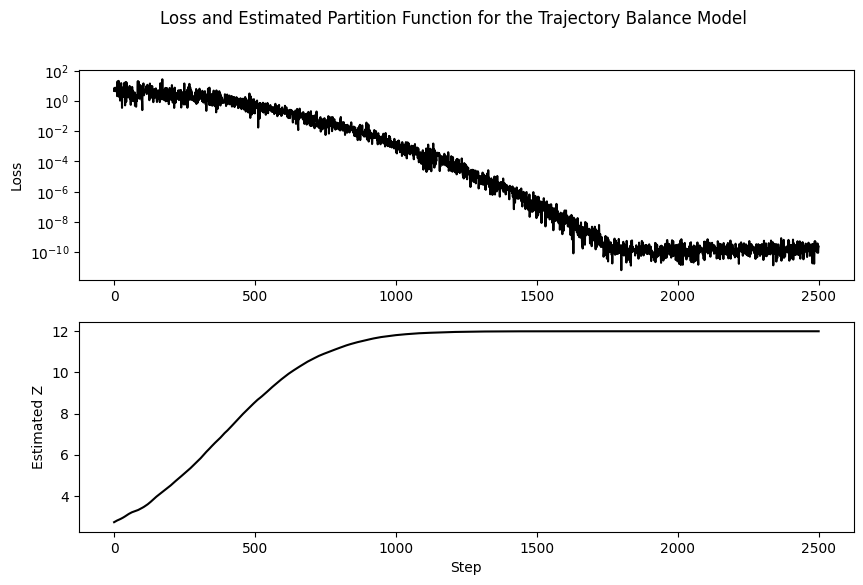

In [189]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
plt.sca(ax[0])
plt.plot(losses, color="black")
plt.yscale('log')
plt.ylabel('Loss')
plt.sca(ax[1])
plt.plot(np.exp(logZs), color="black")
plt.ylabel('Estimated Z');
plt.xlabel('Step')
plt.suptitle("Loss and Estimated Partition Function for the Trajectory Balance Model")

This is the final value we get:

In [190]:
print("The final Z (partition function) estimate is {:.2f}".format(
    model.logZ.exp().item())
)

The final Z (partition function) estimate is 12.00


And we can once again check that we get about 2/3 of smiley samples and only valid samples.

Ratio of faces with a smile:0.6953125, ideal=0.6666666666666666
Proportion of valid faces:1.0, ideal=1


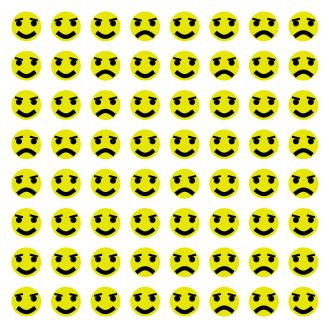

In [191]:
check_sampled_faces(sampled_faces)

# `torchgfn` (Optional)

Now that we've walked through how to sample happy faces twice as often as frowny faces, let's look at how to implement this using the lightweight `torchgfn` library.

We'll duplicate the relevant logic from above, to create self-contained examples below (just make sure you run the first two cells of this notebook to add the features). First, let's set up the python environment.

In [196]:
from torchtyping import TensorType as TT
from typing import ClassVar, Tuple, cast

import gfn
from gfn.actions import Actions
from gfn.env import DiscreteEnv
from gfn.gflownet import FMGFlowNet, TBGFlowNet
from gfn.modules import DiscretePolicyEstimator, ScalarEstimator
from gfn.preprocessors import IdentityPreprocessor
from gfn.states import DiscreteStates
from gfn.utils.modules import NeuralNet

## `torchgfn` Smile Environment

First, we need to define an environment for our `gflownet` to interact with. Face construction (at least, as defined here) is a discrete action space, so we will leverage the `gfn.env.DiscreteEnv` base class, as well as the `Actions` class.

Each environment in torchgfn must generate an instance of the `States` class, which (in the discrete case) uses `masks` to define allowable actions, define whether the trajectory is complete, and backward actions to reach parent states. In `torchgfn` the forward action space (which in our case is the addition of 1 out of 6 facial features) has an additional *exit action*, which the framework uses to end a trajectory. The sampling process continues until all batch elements have exited. In our case, all trajectories are exactly length 3, so this is simple: we mask out the exit action until 3 non-exit actions have been selected, and then we mask all actions *except* exit to ensure the trajectory terminates.

We must also define the `s0` (initial) and `sf` (final) state. In this case, `s0` is simply all zero, and `sf` is all `-1` (but it could be anything that does not look like a normal state tensor).

We also define the `reward` using vectorized logic. Note that `torchgfn` uses `log_rewards()` internally, and since we have a reward of `0`, we must clip the `log_reward` (since `log(0) = -inf`). This clipping is handled automatically for us, and the clipping can be tuned using the `log_reward_clip` flag if so desired.

In [207]:
class FacesEnv(DiscreteEnv):
    def __init__(self, log_reward_clip=-100, mask_invalid_actions=True):
        """Faces environment. States are represented as 6-element binary tensors.

        All trajectories are enforced to be length 3 using states.forward_masks.
        """
        self.feature_keys = [
            'left_eb_down',
            'left_eb_up',
            'right_eb_down',
            'right_eb_up',
            'smile',
            'frown',
        ]
        self.device = torch.device("cpu")
        self.log_reward_clip = log_reward_clip
        self.mask_invalid_actions = mask_invalid_actions

        state_dim = len(self.feature_keys)
        n_actions = state_dim + 1  # all 6 face elements + 1 exit action.

        super().__init__(
            n_actions=n_actions,
            # We start with an empty face.
            s0=torch.zeros(state_dim, dtype=torch.float, device=self.device),
            # Sf represents when a trajectory is done (we selected the exit action).
            sf=torch.ones(state_dim, dtype=torch.float, device=self.device) * -1,
            device_str="cpu",
            # These are sometimes handy to generate tensors. In this case, not needed.
            preprocessor=IdentityPreprocessor(output_dim=state_dim)
        )

    def make_States_class(self) -> type[DiscreteStates]:
        "Creates a States class for this environment"
        env = self

        class FaceStates(DiscreteStates):
            state_shape: ClassVar[tuple[int, ...]] = (env.n_actions - 1,)  # this is 6.
            s0 = env.s0   # this is 6 zeros.
            sf = env.sf   # this is 6 -1's.
            n_actions = env.n_actions  # this is 7. 6 features, plus 1 for exit.
            device = env.device

            def update_masks(self) -> None:
                "Update the masks based on the current states."
                # Backward masks are simply any action we've already taken.
                self.backward_masks = self.tensor != 0  # n - 1 actions.

                # Forward masks begin as allowing any action. Allowed actions are 1.
                self.init_forward_masks(set_ones=True)

                # Then, we remove any done action, and also the exit action.
                self.set_nonexit_masks(self.tensor == 1, allow_exit=False)

                if env.mask_invalid_actions:
                    # Now we remove invalid actions. Here we are enforcing that
                    # only one left eyebrow, one right eyebrow, and one smile can be
                    # selected. 0 = not allowed.
                    invalid_actions = torch.ones(self.forward_masks.shape).bool()
                    invalid_actions[..., 0][self.tensor[..., 1].bool()] = 0  # l_eb
                    invalid_actions[..., 1][self.tensor[..., 0].bool()] = 0  # l_eb
                    invalid_actions[..., 2][self.tensor[..., 3].bool()] = 0  # r_eb
                    invalid_actions[..., 3][self.tensor[..., 2].bool()] = 0  # r_eb
                    invalid_actions[..., 4][self.tensor[..., 5].bool()] = 0  # smile
                    invalid_actions[..., 5][self.tensor[..., 4].bool()] = 0  # smile

                    self.forward_masks = (self.forward_masks * invalid_actions)

                # Trajectories must be length 3. Any trajectory that has taken 3 actions
                # should be forced to exit.
                batch_idx = self.tensor.sum(-1) >= 3
                self.set_exit_masks(batch_idx)

        return FaceStates

    def maskless_step(
        self, states: DiscreteStates, actions: Actions
    ) -> TT["batch_shape", "state_shape", torch.float]:
        return states.tensor.scatter(-1, actions.tensor, 1, reduce="add")

    def maskless_backward_step(
        self, states: DiscreteStates, actions: Actions
    ) -> TT["batch_shape", "state_shape", torch.float]:
        return states.tensor.scatter(-1, actions.tensor, -1, reduce="add")

    def reward(self, states: DiscreteStates) -> TT["batch_shape", torch.float]:
        """The face reward is calculated as:
            + 0 if the face is invalid (overlapping features OR not satisfying
                the constraint of 2 eyebrows and 1 mouth).
                + This will only be possible if `mask_invalid_actions` is False.
            + 1 if the face is frowny. :(
            + 2 if the face is smiley. :)
        """
        if not env.mask_invalid_actions:
            # Tensor organization is [left_eb *2, right_eb * 2, mouth * 2]
            valid = torch.zeros(states.batch_shape + (3,))
            valid[..., 0] = states.tensor[..., :2].sum(-1) == 1  # One left eyebrow.
            valid[..., 1] = states.tensor[..., 2:4].sum(-1) == 1  # One right eyebrow.
            valid[..., 2] = states.tensor[..., 4:].sum(-1) == 1  # One mouth.
            valid = valid.prod(-1, keepdim=True)  #  Two eyebrows, one mouth.

        # Add the emotion rewards.
        rewards = torch.zeros(states.batch_shape + (1,))
        rewards[states.tensor[..., 4] == 1] = torch.tensor([2])  # Smiles.
        rewards[states.tensor[..., 5] == 1] = torch.tensor([1])  # Frowns.

        if not env.mask_invalid_actions:
            rewards = rewards * valid  # This will remove any double mouths.

        return rewards.squeeze()

env = FacesEnv()

# A `torchgfn` Training Loop

In this simple example, we use the environment's `States` class to keep track of our terminal states (our sampled faces). Our `gflownet` allows us to sample batches of trajectories, and allows us to calculate the loss using the `env` (which contains our reward function) and `samples`.

In [208]:
def train(gflownet, optimizer, env, batch_size = 128, n_episodes = 25_000):
    """Training loop, keeping track of terminal states over training."""
    # This stores example terminating states.
    visited_terminating_states = env.States.from_batch_shape((0,))
    states_visited = 0
    losses = []

    for iteration in trange(n_episodes // batch_size):
        trajectories = gflownet.sample_trajectories(env, n_samples=batch_size)
        samples = gflownet.to_training_samples(trajectories)
        optimizer.zero_grad()
        loss = gflownet.loss(env, samples)
        loss.backward()
        optimizer.step()

        visited_terminating_states.extend(trajectories.last_states)
        states_visited += len(trajectories)
        losses.append(loss.item())

    return visited_terminating_states, states_visited, losses

## Flow Matching with `torchgfn`

The details of the Flow Matching objective are handled within the `FMGFlowNet` class, which requires us to provide it with an `estimator`, which is simply a neural network that accepts a state and produces logits over next actions. Under the hood, all `gflownets` in `torchgfn` inherit from `nn.Module` and function as expected (e.g., see `gflownet.parameters()`).

Note that for numerical stability reasons, we estimate the log edge flows here, not the edge flows as we did in the above example.

In [209]:
# nn.Module that estimates _log_ edge flows.
module = NeuralNet(
    input_dim=env.preprocessor.output_dim,
    output_dim=env.n_actions,
    hidden_dim=n_hid_units,
    n_hidden_layers=1,
)
# This is our _log_ edge flow estimator.
estimator = DiscretePolicyEstimator(
    module=module,
    n_actions=env.n_actions,
    preprocessor=env.preprocessor,
)

# The gflownet class wraps our estimator (inclusing sampler functionality).
gflownet = FMGFlowNet(estimator)
optimizer = torch.optim.Adam(gflownet.parameters(), lr=learning_rate)  # TODO: Verify.

visited_terminating_states, states_visited, losses = train(
    gflownet,
    optimizer,
    env,
    n_episodes=n_episodes * 10,
)

AttributeError: 'FaceStates' object has no attribute 'init_forward_masks'

We can now see that our flow matching network is sampling faces as expected:

In [ ]:
analyze_torchgfn_results(visited_terminating_states, env)

And our loss curve is reasonable:

In [ ]:
plot_loss_curve(losses, title="Loss Curve for Flow Matching Objective using TorchGFN")

To evaluate the flows at $S_0$, we first need to make an instance of the env's `States` class, and then pass that class an all-zero (empty) state. Finally, this $S_0$ states object can be passed to our trained estimator (estimators are wrappers for `nn.Modules`,
which know to handle `States` classes).


In [ ]:
# Note that here, we have the log edge flows, so we take the sum(exp(log_flows)) to
# calculate the partition function estimate.
s_0 = env.make_States_class()(torch.zeros(6))
print("Partition function estimate Z={:.2f}".format(
    sum(torch.exp(estimator(s_0)[:6]))  # logsumexp.
    )
)

# Trajectory Balance with `torchgfn`

Similarly, we can train a gflownet using Trajectory Balance using the `TBGFlowNet` class. Unlike before, we separately parameterize the forward and backward policies are two different `estimators`, which are passed to the `TBGFlowNet`. In this example we don't use a replay buffer, so we set `on_policy=True`.

One common trick with trajectory balance is to learn the `logZ` parameter with a higher learning rate than the rest of the network.

In [ ]:
# nn.Modules for the forward and backward policy estimators.
pf_module = NeuralNet(
    input_dim=env.preprocessor.output_dim,
    output_dim=env.n_actions,
    hidden_dim=n_hid_units,
    n_hidden_layers=1,
)
pb_module = NeuralNet(
    input_dim=env.preprocessor.output_dim,
    output_dim=env.n_actions - 1,
    hidden_dim=n_hid_units,
    n_hidden_layers=1,
)
# Estimators for the forward and backward policies.
pf_estimator = DiscretePolicyEstimator(
    module=pf_module,
    n_actions=env.n_actions,
    preprocessor=env.preprocessor,
)
pb_estimator = DiscretePolicyEstimator(
    module=pb_module,
    n_actions=env.n_actions,
    is_backward=True,
    preprocessor=env.preprocessor,
)

# Our trajectory balance gflownet accepts both policy estimators.
gflownet = TBGFlowNet(
    pf=pf_estimator,
    pb=pb_estimator,
    on_policy=True,  # No replay buffer.
)

# Policy parameters recieve one LR, and LogZ gets a dedicated, typically higher LR.
params = [
    {"params": [
        v for k, v in dict(gflownet.named_parameters()).items() if k != "logZ"
        ],
     "lr": learning_rate,
    }
]
params.append(
    {"params": [
        dict(gflownet.named_parameters())["logZ"]
        ],
     "lr": learning_rate * 10,
     }
)
optimizer = torch.optim.Adam(params)

visited_terminating_states, states_visited, losses = train(
    gflownet,
    optimizer,
    env,
    n_episodes=n_episodes * 10,
)

In [ ]:
analyze_torchgfn_results(visited_terminating_states, env)

In [ ]:
plot_loss_curve(losses, title="Loss Curve for Trajectory Balance Objective using TorchGFN")

In [ ]:
print("The partition function estimate is Z={:.2f}".format(
    torch.exp(gflownet.logZ).item()
    )
)